In [436]:
#Необходимые библиотеки
import json
import math
#import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split # cross_validation
from __future__ import division
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn import svm
import seaborn
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from sklearn.feature_selection import SelectKBest
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Считывание данных

In [449]:
#Считываем данные с файла
input_file = open(r'cc_train_08+1.csv')
X_0=pd.read_csv(input_file, sep=';')
input_file = open(r'cc_delay_08+2.csv')
Y_0=pd.read_csv(input_file, sep=';')


In [476]:
X_0.describe()

,INCOME,PAID_AMT12M,LAST_DLQ_AMT,MAX_DLQ3M,MAX_DLQ6M,MAX_DLQ12M,MAX_DLQ,DAYS_IN_DLQ,PAID_DLQ3M,PAID_DLQ6M,...,RATE_TPC,CNT_DAYS,CNT_PROMISE,AMOUNT,MAX_PROMISE,MAX_DIS,KEPTS_1,KEPTS_2,KEPTS_CONTACTS,KEPTS_CALL
count,86198.000000,135450.000000,135450.000000,135450.000000,135450.000000,135450.000000,135450.000000,135450.000000,135450.000000,135450.000000,...,18886.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.020928,0.194456,0.292178,0.198307,0.234797,0.342627,0.327011,0.435549,0.535499,0.676950,...,0.806548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.999781,0.980911,0.956364,0.980140,0.972044,0.939471,0.945020,0.900164,0.844534,0.736027,...,0.591140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000002,0.000041,0.000012,0.108662,0.012585,0.007867,0.005359,0.003705,0.293425,0.422945,...,0.004023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.007953,0.115343,0.195806,0.108662,0.144222,0.205213,0.197052,0.276230,0.293425,0.422945,...,0.600518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.012800,0.115343,0.247601,0.108662,0.144222,0.205213,0.237534,0.305188,0.293425,0.422945,...,0.600518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.019165,0.115343,0.247601,0.108662,0.144222,0.205213,0.237534,0.305188,0.293425,0.422945,...,0.600518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,207.508709,235.401609,238.287195,81.608809,76.336706,43.121050,47.625845,51.868918,8.378705,7.447356,...,3.177285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Удаление "пустых" данных и разбиение на выборки

In [450]:
#Удаляем столбцы с 95% NULL
y = X_0['TARGET']
y1= Y_0['TARGET']
  
Z_train_1=y
Z_delay_1=y1
p=len(Z_train_1.index)

for col in X_0.columns:
    if X_0[col].isnull().sum()/p<0.95:
        Z_train=X_0[col]
        Z_delay=Y_0[col]
        Z_train_1=pd.concat([Z_train_1,Z_train],axis=1)
        Z_delay_1=pd.concat([Z_delay_1,Z_delay],axis=1)

Z_train_1 = Z_train_1.drop(['TARGET'],axis=1)
Z_delay_1 = Z_delay_1.drop(['TARGET'],axis=1)
X = Z_train_1
Y_0 = Z_delay_1

In [451]:
#Удаляем столбцы с 95% выбросов
for col in X.columns:
    avg = X[col].mean()
    st = X[col].std()
    X_0[col] = np.abs((X[col]-avg)/st)

Z_train_1 = y
Z_delay_1 = y1
p = len(Z_train_1.index)
for col in X.columns:
    if (X_0[col]>3.0).sum()/p<0.05:
        Z_train=X[col]
        Z_delay=Y_0[col]
        Z_train_1=pd.concat([Z_train_1,Z_train],axis=1)
        Z_delay_1=pd.concat([Z_delay_1,Z_delay],axis=1)
        #print((X_0_tr[col]>3.0).sum())
Z_train_1 = Z_train_1.drop(['TARGET'],axis=1)
Z_delay_1 = Z_delay_1.drop(['TARGET'],axis=1)


X = Z_train_1



Y_0=Z_delay_1

In [452]:
data={}
data_y={}
data['train'], data['test'], data_y['train'], data_y['test'] = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 155)
data_y['delay'] = y1
data['delay'] = Y_0

In [453]:
for i in data:
    data[i].fillna(-1, inplace=True)

## Отбор признаков

In [402]:
#Feature Selection with RFE
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(data['train'], data_y['train'] )
rank = rfe.ranking_
print(rfe.support_)
print(rfe.ranking_)


[False False False  True  True  True False False False False  True  True
  True False False False False False False False False False False  True
  True False  True False  True False False False False False  True  True
  True  True  True  True  True  True]
[14 15 12  1  1  1  4  5 20 18  1  1  1 11 10  7  8  9 19 13 24 25 23  1
  1 22  1 21  1  2  3  6 16 17  1  1  1  1  1  1  1  1]


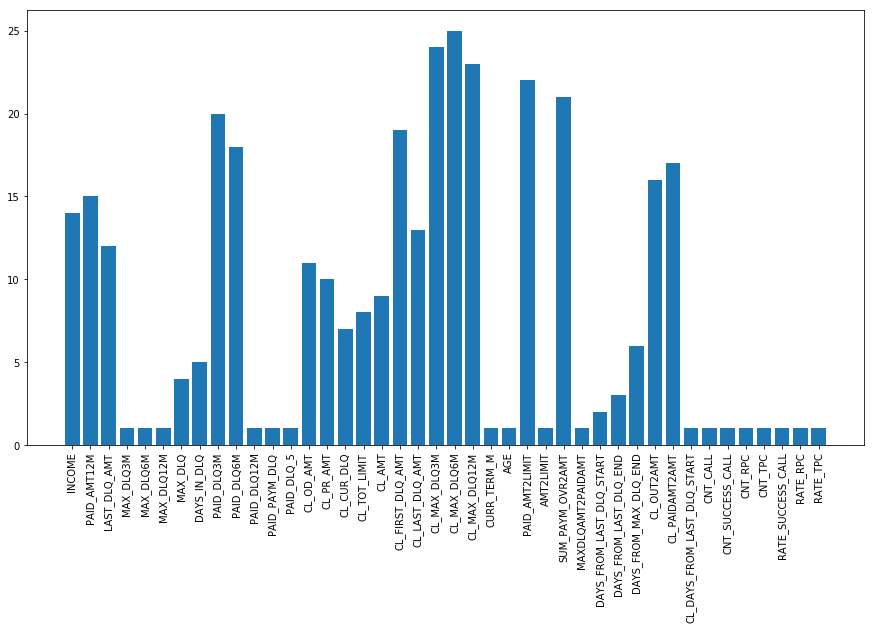

In [405]:
plt.figure(figsize=(15,8))
plt.bar(data['train'].columns, rfe.ranking_)
plt.xticks(range(len(data['train'].columns)), data['train'].columns, rotation='vertical')
plt.show()

### Оценка важности

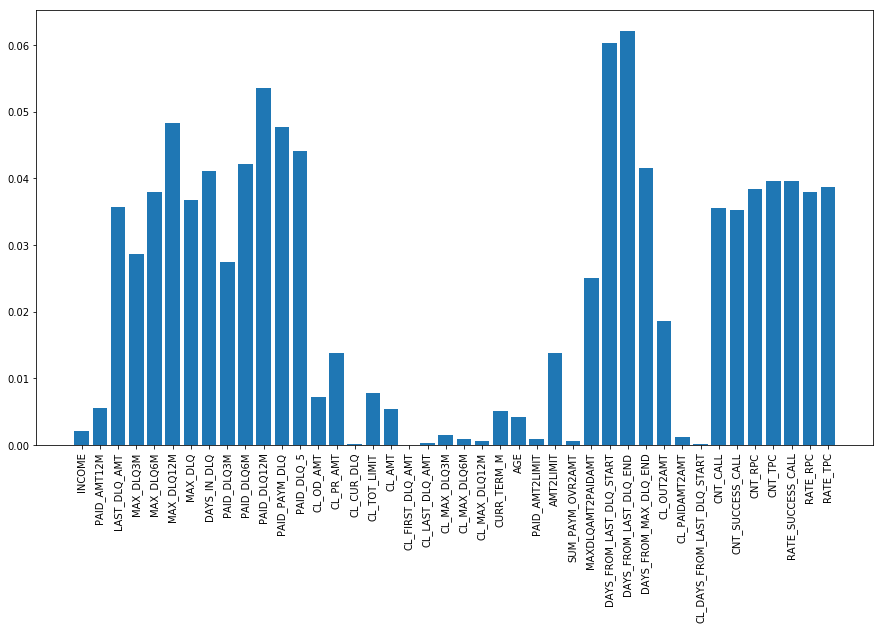

In [407]:
#Importance score

predictors=data['train'].columns
select = SelectKBest(mutual_info_classif, k=15)
select=select.fit(data['train'], data_y['train'])
X_new = select.transform(data['train'])
scores = select.scores_

plt.figure(figsize=(15,8))
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [454]:
#Create array of good features 
Predictors = np.empty(0)

for i in range(len(predictors)):
    #print(predictors[i], scores[i], rank[i])
    if (scores[i] > 0.02) & (rank[i] <= 6):
        Predictors = np.append(Predictors, predictors[i])
        
print(Predictors)

['MAX_DLQ3M' 'MAX_DLQ6M' 'MAX_DLQ12M' 'MAX_DLQ' 'DAYS_IN_DLQ'
 'PAID_DLQ12M' 'PAID_PAYM_DLQ' 'PAID_DLQ_5' 'MAXDLQAMT2PAIDAMT'
 'DAYS_FROM_LAST_DLQ_START' 'DAYS_FROM_LAST_DLQ_END'
 'DAYS_FROM_MAX_DLQ_END' 'CNT_CALL' 'CNT_SUCCESS_CALL' 'CNT_RPC' 'CNT_TPC'
 'RATE_SUCCESS_CALL' 'RATE_RPC' 'RATE_TPC']


In [455]:
#delete bad features
Predictors = ['MAX_DLQ6M','MAX_DLQ12M','DAYS_IN_DLQ','PAID_DLQ6M','PAID_DLQ12M','PAID_PAYM_DLQ','PAID_DLQ_5','DAYS_FROM_LAST_DLQ_START',
              'DAYS_FROM_LAST_DLQ_END','DAYS_FROM_MAX_DLQ_END','CNT_TPC','RATE_SUCCESS_CALL','RATE_TPC']

for i in data:
    data[i] = data[i][Predictors]

## График распределений

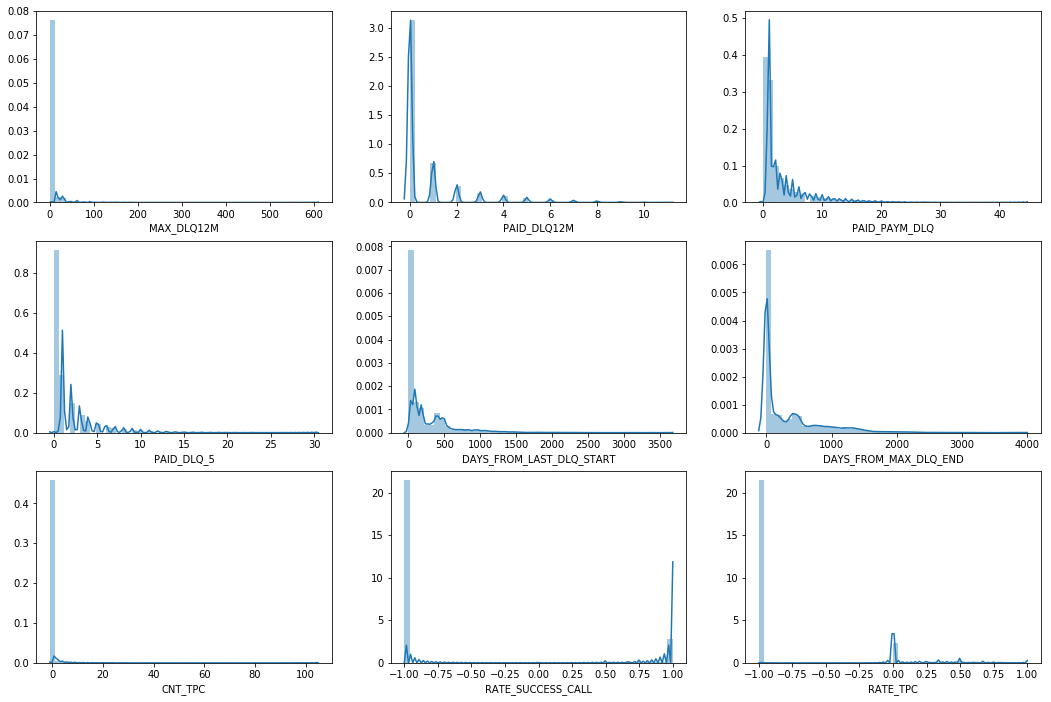

In [457]:
norm_pred = [ 'MAX_DLQ12M' ,'PAID_DLQ12M', 'PAID_PAYM_DLQ','PAID_DLQ_5' , 'DAYS_FROM_LAST_DLQ_START', 'DAYS_FROM_MAX_DLQ_END' , 'CNT_TPC',
             'RATE_SUCCESS_CALL',  'RATE_TPC']
fig, axes = plt.subplots(3,3, figsize = (18,12))
for i in range(len(norm_pred)):
    seaborn.distplot(data['train'][norm_pred[i]].dropna(), bins = 50, ax = axes[int(i/3),i%3])

## Поиск аномалий

0.3164


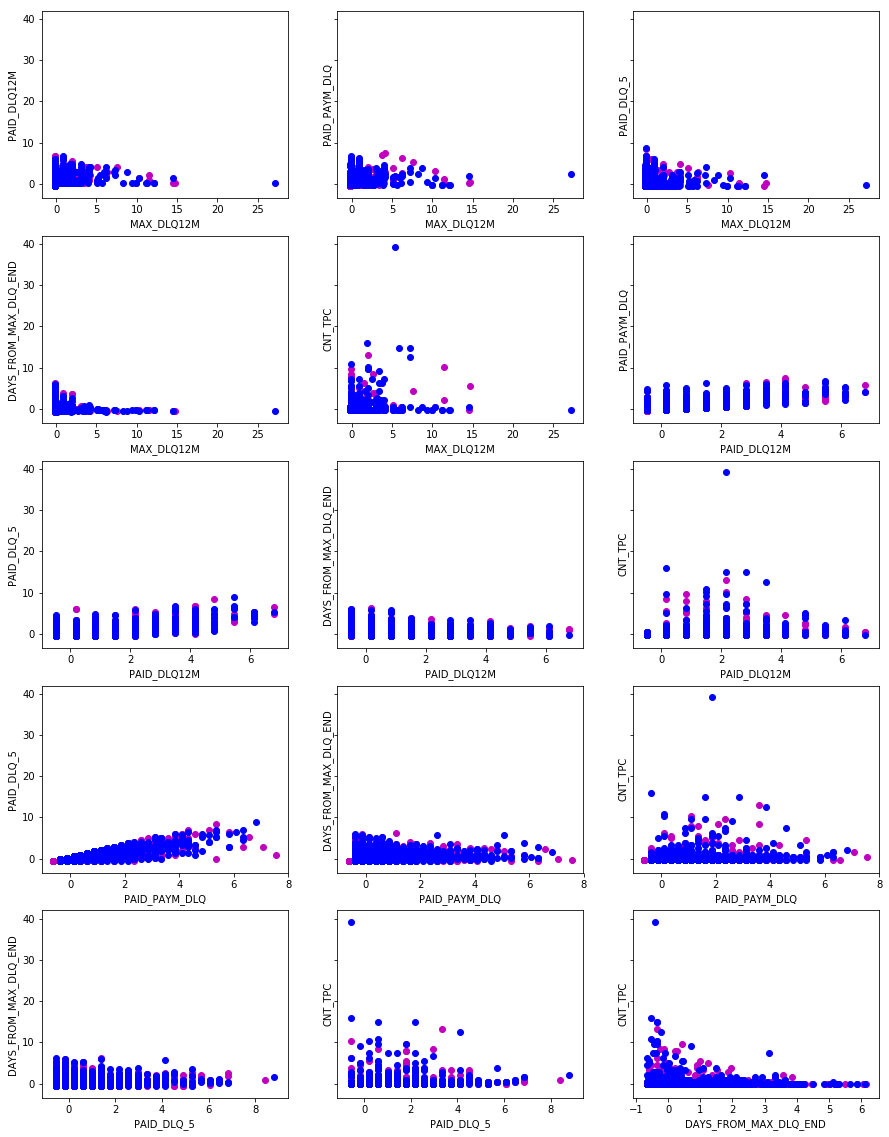

In [489]:
#нормировка
X_0_n=data['train']
for col in data['train'].columns:
    avg=data['train'][col].mean()
    st=data['train'][col].std()
    X_0_n[col]=(data['train'][col]-avg)/st

#поиск аномалий
norm_features = [ 'MAX_DLQ12M' ,'PAID_DLQ12M', 'PAID_PAYM_DLQ','PAID_DLQ_5' , 'DAYS_FROM_MAX_DLQ_END' , 'CNT_TPC']
nn=5000
svm_ = svm.OneClassSVM(kernel='rbf',gamma=10, nu=0.05) 
svm_.fit(X_0_n[norm_features][:nn])
labels = svm_.predict(X_0_n[norm_features][:nn])
counter = 0
fig, axes = plt.subplots(5, 3, sharey=True, figsize = (15, 20))

for feat1 in range(len(norm_features)):
    for feat2 in range(len(norm_features)):
        if feat1 >= feat2:
            continue
        axes[int(counter / 3),counter % 3].scatter(np.array(X_0_n[norm_features[feat1]][:nn].loc[labels == -1]), np.array(X_0_n[norm_features[feat2]][:nn].loc[labels == -1]), c ='m')
        axes[int(counter / 3),counter % 3].scatter(np.array(X_0_n[norm_features[feat1]][:nn].loc[labels == 1]), np.array(X_0_n[norm_features[feat2]][:nn].loc[labels == 1]), c = 'b')
        axes[int(counter / 3),counter % 3].set_xlabel(norm_features[feat1])
        axes[int(counter / 3),counter % 3].set_ylabel(norm_features[feat2])
        counter += 1
print(sum(labels==1)/nn)

## Построение модели

In [439]:
#Logistic Regression
clf = LogisticRegression(random_state=1,class_weight='balanced',C=0.1,max_iter=500)
clf.fit(data['train'], data_y['train'])

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Gini
train 0.6068761128662499
test 0.6061983608071142
delay 0.6012547636203724


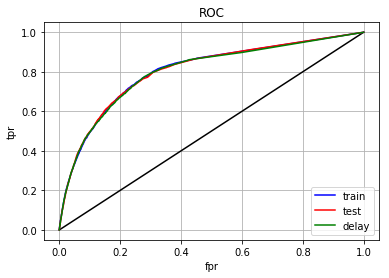

In [440]:
y_pred={}
# Gini
print('Gini')
for i in data:
    y_pred[i]=clf.predict_proba(data[i])[:,1]
    
    print(i, (roc_auc_score(data_y[i], y_pred[i]))*2-1)

#ROC graph

plt.plot([0,1], [0,1], color='black')
colors = {}
colors['train']='b'
colors['test']='r'
colors['delay']='g'
fpr = {}
tpr = {}
for i in data:
    fpr[i], tpr[i], thresholds = metrics.roc_curve(data_y[i], y_pred[i])
    plt.plot(fpr[i], tpr[i],colors[i], label=i)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [441]:
# R^2 score
print('R^2 score')
for i in data:
    print(i, metrics.r2_score(data_y[i], y_pred[i]))

# MSE
print('\nMSE')
for i in data:
    print(i, metrics.mean_squared_error(data_y[i], y_pred[i]))


R^2 score
train -1.032036906192019
test -1.0717884942755944
delay -0.5376733745380702

MSE
train 0.16997589282669837
test 0.16917132570999047
delay 0.16486967207218933


## Анализ корреляций

MAX_DLQ6M MAX_DLQ12M 0.5743279567128298
PAID_DLQ6M PAID_DLQ12M 0.8432378224542972
PAID_DLQ6M PAID_PAYM_DLQ 0.620711518180576
PAID_DLQ6M PAID_DLQ_5 0.6379022819079897
PAID_DLQ6M RATE_SUCCESS_CALL 0.673413027383616
PAID_DLQ6M RATE_TPC 0.6669216281648448
DAYS_FROM_LAST_DLQ_START DAYS_FROM_LAST_DLQ_END 0.9972431315731476
DAYS_FROM_LAST_DLQ_START DAYS_FROM_MAX_DLQ_END 0.6835588617795405


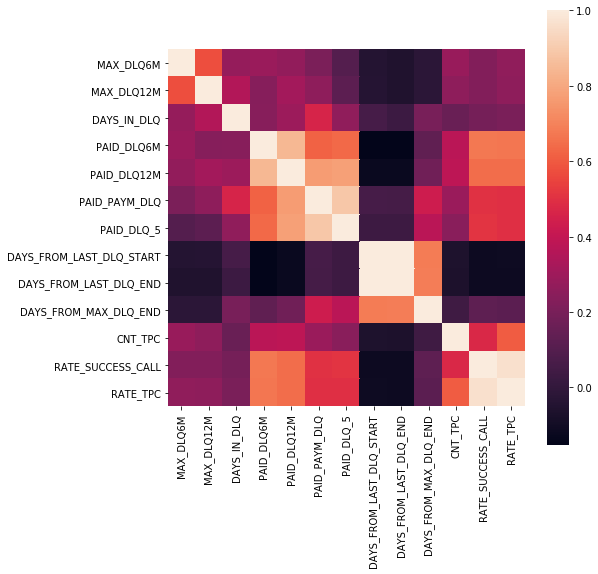

In [459]:
#анализ данных
#корреляции
CorrKoef = data['train'].corr()
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[abs(CorrKoef[i]) > 0.5]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print (i,j, CorrKoef[i][CorrKoef.index==j].values[0])

a4_dims = (8, 8)
fig, ax = plt.subplots(figsize=a4_dims)
seaborn.heatmap(CorrKoef,ax=ax,square=True)

## P-value

In [288]:
# p-value
for i in data:
    logit_model=sm.Logit(data_y[i], data[i])
    result=logit_model.fit()
    print(result.summary())

Optimization terminated successfully.
         Current function value: 0.280880
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                94815
Model:                          Logit   Df Residuals:                    94802
Method:                           MLE   Df Model:                           12
Date:                Fri, 17 Aug 2018   Pseudo R-squ.:                 0.08644
Time:                        09:29:15   Log-Likelihood:                -26632.
converged:                       True   LL-Null:                       -29151.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
MAX_DLQ6M                    0.0074      0.001      5.510      0.000       0.005

##  Weight of Evidence, Information Value

In [356]:
# Calculate Weight of Evidence
def calc_woe(df, feature, target):
    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (target == 0)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]
    
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data = data[data['Distribution Good'] > 0]
    
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    return data

# Calculate information value
def calc_iv(df, feature, target):
    data = calc_woe(df, feature, target)
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()
    data = data.sort_values(by=['Variable', 'Value'], ascending=True)
    return data['IV'].values[0]

In [349]:
# IV
for i in data['train']:
    print(i, calc_iv(data['train'], i, data_y['train']))


MAX_DLQ6M 0.8658102775435031
MAX_DLQ12M 1.158493831999192
DAYS_IN_DLQ 1.1064152731703036
PAID_DLQ6M 0.8863263438659138
PAID_DLQ12M 1.2811268584004671
PAID_PAYM_DLQ 1.122237551103338
PAID_DLQ_5 1.053406113881298
DAYS_FROM_LAST_DLQ_START 1.4427819693478157
DAYS_FROM_LAST_DLQ_END 1.492279951942979
DAYS_FROM_MAX_DLQ_END 1.1362715805210726
CNT_TPC 0.5283381207044968
RATE_SUCCESS_CALL 0.5393558804215431
RATE_TPC 0.5407851860413609


## Binning

In [471]:
def binning(col, group, labels=None):
      #Define min and max values:
      minval = col.min()
      maxval = col.max()

      if group == 1:
            h = (maxval - minval)/10000
            cut_points = [minval + h, minval + 20 * h ]
      elif (group == 2):
            h = (maxval - minval)/30000
            cut_points = [minval + h, minval + 1000 * h ]
      elif (group == 3):
            h = (maxval - minval)/3
            cut_points = [minval + h, minval + 2 * h ]
      elif group == 4:
            h = (maxval - minval)/3000000
            cut_points = [minval + h]
      elif group == 5:
            cut_points = [-0.5533973, 0]
      #create list by adding min and max to cut_points
      break_points = [minval] + cut_points + [maxval]

      #if no labels provided, use default labels 0 ... (n-1)
      if not labels:
        labels = range(len(cut_points)+1)


      print(break_points)
      #Binning using cut function of pandas
      colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
      return colBin, cut_points
    
def binning_woe(col, labels=None):
      #Define min and max values:
      minval = col.min()
      maxval = col.max()
      h = (maxval - minval)/16
      cut_points = [minval + 6 * h, minval + 9 * h,  minval + 11 * h ]
      #create list by adding min and max to cut_points
      break_points = [minval] + cut_points + [maxval]

      #if no labels provided, use default labels 0 ... (n-1)
      if not labels:
        labels = range(len(cut_points)+1)


      print(break_points)
      #Binning using cut function of pandas
      colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
      return colBin, cut_points


[-0.20244137557657949, -0.1982274091247402, -0.11816204653979412, 41.93722314281611]
MAX_DLQ12M 
 0    65557
1    20720
2     8538
Name: MAX_DLQ12M, dtype: int64
94815


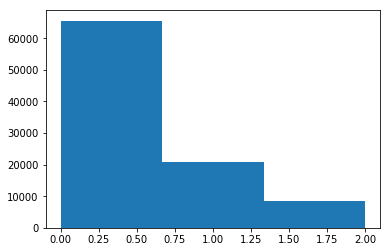

[-0.3050376346251668, -0.2998373642169354, -0.2010322264605384, 51.697666447689045]
DAYS_IN_DLQ 
 0    44864
1    19864
2    30087
Name: DAYS_IN_DLQ, dtype: int64
94815


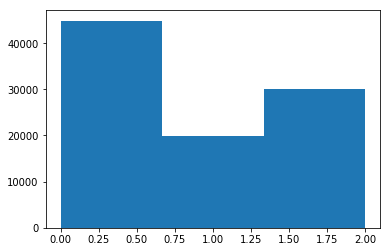

[-0.6208214608792632, -0.6204576669118582, -0.2570274934743612, 10.292997561267796]
PAID_PAYM_DLQ 
 0    32842
1    27648
2    34325
Name: PAID_PAYM_DLQ, dtype: int64
94815


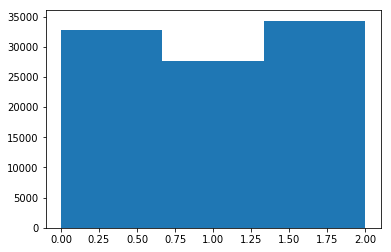

[-0.5656724894393939, -0.565310517676362, -0.20370072640754877, 10.293480401515959]
DAYS_FROM_LAST_DLQ_START 
 0    45642
1    14943
2    34230
Name: DAYS_FROM_LAST_DLQ_START, dtype: int64
94815


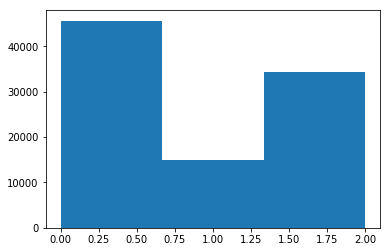

[-0.5619490329971878, -0.5615832103212387, -0.1961263570481051, 10.412731245475294]
DAYS_FROM_LAST_DLQ_END 
 0    45642
1    15505
2    33668
Name: DAYS_FROM_LAST_DLQ_END, dtype: int64
94815


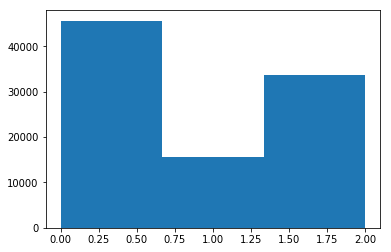

[-0.6676287885284816, -0.6673705730567021, -0.40941331674897913, 7.0788353648565945]
DAYS_FROM_MAX_DLQ_END 
 0    44864
1     7299
2    42652
Name: DAYS_FROM_MAX_DLQ_END, dtype: int64
94815


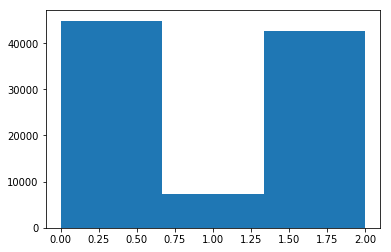

[-0.19820838077759265, -0.19615980965803184, 1.8503627387832031, 61.258925206046285]
CNT_TPC 
 0    81480
1    11414
2     1921
Name: CNT_TPC, dtype: int64
94815


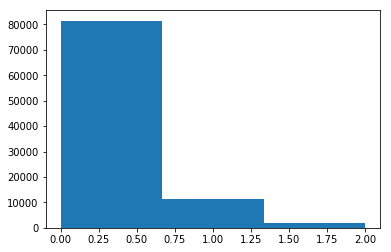

[-0.3927662061660526, 1.214115592874125, 2.8209973919143025, 4.42787919095448]
RATE_TPC 
 0    81480
1    10670
2     2665
Name: RATE_TPC, dtype: int64
94815


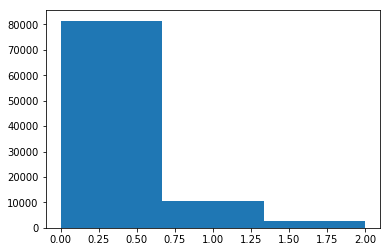

[-0.14382457868750828, -0.14379931824231199, 75.63751101018666]
MAX_DLQ6M 
 0    75805
1    19010
Name: MAX_DLQ6M, dtype: int64
94815


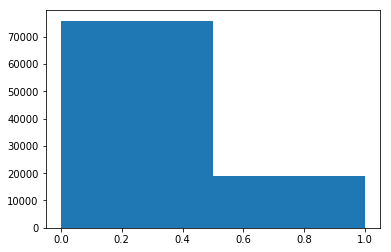

[-0.4236614939815764, -0.42365887511633193, 7.432934239342379]
PAID_DLQ6M 
 0    75805
1    19010
Name: PAID_DLQ6M, dtype: int64
94815


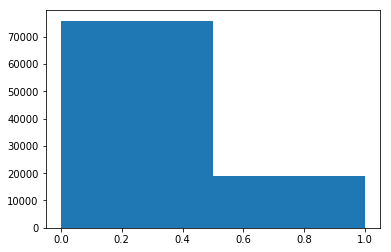

[-0.48192316668350005, -0.48192074484194886, 6.783601486974446]
PAID_DLQ12M 
 0    65557
1    29258
Name: PAID_DLQ12M, dtype: int64
94815


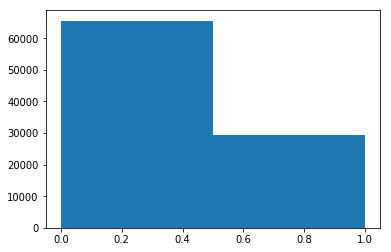

[-0.5537870237757312, -0.5533973, 0, 11.135893352756728]
PAID_DLQ_5 
 0    52190
1    16494
2    26131
Name: PAID_DLQ_5, dtype: int64
94815


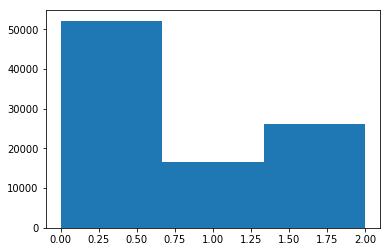

In [472]:
# Binning with values

group = {}
group[1] = ['MAX_DLQ12M','DAYS_IN_DLQ']
group[2] = ['PAID_PAYM_DLQ','DAYS_FROM_LAST_DLQ_START','DAYS_FROM_LAST_DLQ_END','DAYS_FROM_MAX_DLQ_END','CNT_TPC']
group[3] = ['RATE_TPC']
group[4] = ['MAX_DLQ6M','PAID_DLQ6M','PAID_DLQ12M']
group[5] = ['PAID_DLQ_5']


for j in range(1, 6):
    for i in group[j]:     
        new_data, cut_points = binning(data['train'][i].dropna(), group=j)
        print(i, '\n', pd.value_counts(new_data, sort=False))
        print(new_data.count())
        plt.hist(new_data, bins=len(cut_points)+1)
        plt.show()


[-0.6747804520690895, 1.041366071520923, 1.8994393333159296, 2.4714881745126003, 3.901610277504277]
MAX_DLQ6M 
 0     9
1    36
2    23
3    12
Name: WoE, dtype: int64
80


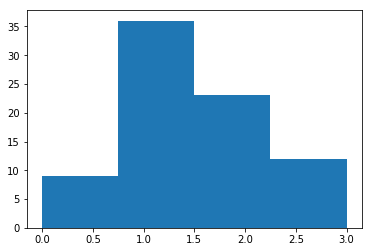

[-1.1166157856675818, 0.8629164071272484, 1.8526825035246632, 2.5125265677896067, 4.162136728451965]
MAX_DLQ12M 
 0    14
1    60
2    40
3    18
Name: WoE, dtype: int64
132


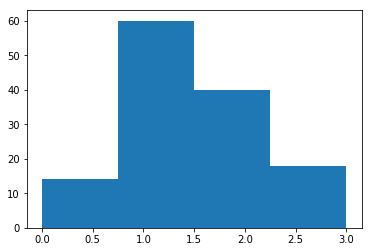

[-1.4351780626738535, 0.484600620839569, 1.4444899625962802, 2.084416190434088, 3.6842317600286068]
DAYS_IN_DLQ 
 0     34
1    235
2    154
3     91
Name: WoE, dtype: int64
514


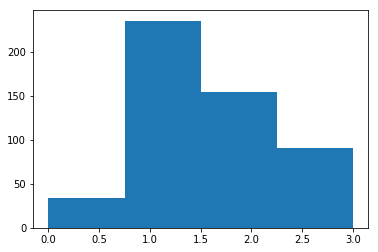

[-0.6791397568961923, 0.693397742241012, 1.3796664918096144, 1.837178991522016, 2.98096024080302]
PAID_DLQ6M 
 0    1
1    1
2    1
3    4
Name: WoE, dtype: int64
7


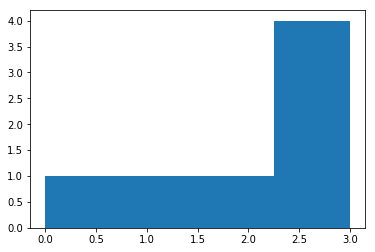

[-1.1191372769748806, 0.3200126930165228, 1.0395876780122246, 1.5193043346760255, 2.7185959763355285]
PAID_DLQ12M 
 0    1
1    2
2    1
3    8
Name: WoE, dtype: int64
12


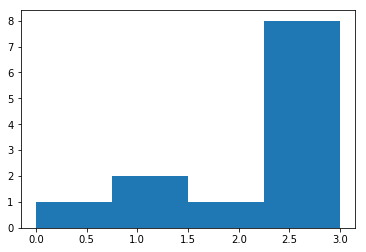

[-1.4266639415392928, 0.22632392642818178, 1.0528178604119192, 1.6038138164010771, 2.981303706373973]
PAID_PAYM_DLQ 
 0     3
1     5
2     5
3    25
Name: WoE, dtype: int64
38


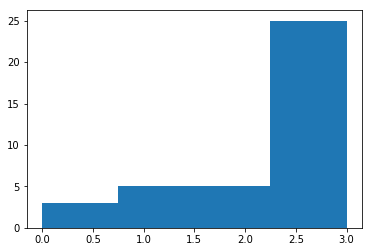

[-1.2252651788120776, 0.6958071775854995, 1.6563433557842882, 2.296700807916814, 3.897594438248128]
PAID_DLQ_5 
 0     3
1     7
2    11
3     6
Name: WoE, dtype: int64
27


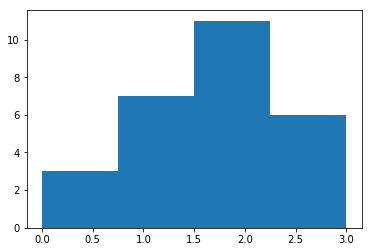

[-2.7152170752306053, -0.6946028207433774, 0.3157043065002365, 0.9892423913293125, 2.673087603402003]
DAYS_FROM_LAST_DLQ_START 
 0    31
1    43
2    14
3    17
Name: WoE, dtype: int64
105


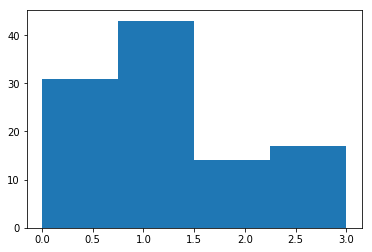

[-2.3440501038207673, 0.03325380135475564, 1.2219057539425169, 2.014340389001025, 3.995426976647294]
DAYS_FROM_LAST_DLQ_END 
 0    116
1    148
2     61
3     55
Name: WoE, dtype: int64
380


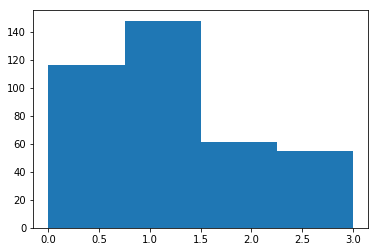

[-1.8844595845938201, 0.35571901985715293, 1.4758083220826395, 2.2225345235662965, 4.089350027275441]
DAYS_FROM_MAX_DLQ_END 
 0    160
1    280
2    123
3    141
Name: WoE, dtype: int64
704


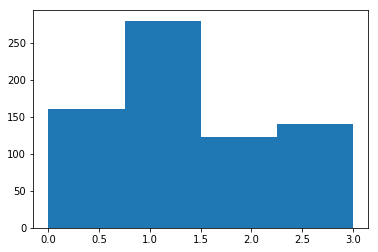

[-0.4174617856411193, 0.5977037244710759, 1.1052864795271737, 1.4436749828979054, 2.289646241324735]
CNT_TPC 
 0     4
1     3
2    10
3    14
Name: WoE, dtype: int64
31


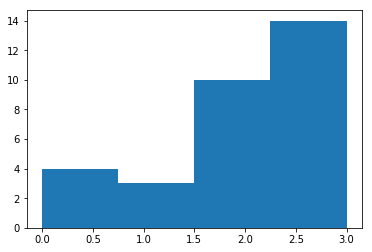

[-0.4144756802868314, 1.1205502152453228, 1.8880631630114, 2.3997384615221184, 3.678926707798914]
RATE_SUCCESS_CALL 
 0     8
1    43
2    20
3    14
Name: WoE, dtype: int64
85


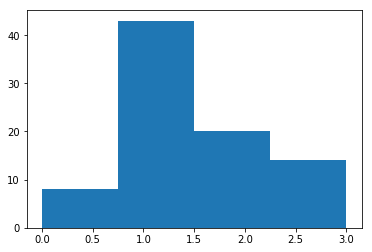

[-0.4153954320187193, 1.0117496863440172, 1.7253222455253856, 2.201037284979631, 3.3903248836152446]
RATE_TPC 
 0    13
1    51
2    23
3    26
Name: WoE, dtype: int64
113


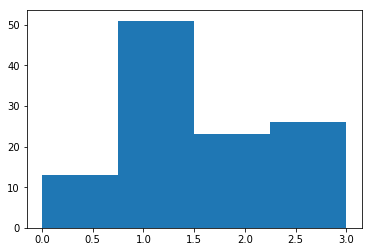

In [473]:
#Binning with WoE

for i in data['train']:  
    new_data, cut_points = binning_woe(calc_woe(data['train'], i, data_y['train'])['WoE'])
    print(i, '\n', pd.value_counts(new_data, sort=False))
    print(new_data.count())
    plt.hist(new_data, bins=len(cut_points)+1)
    plt.show()